# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-19 00:56:12--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M   781KB/s    in 30s     

2022-09-19 00:56:43 (3.68 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [3]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [4]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

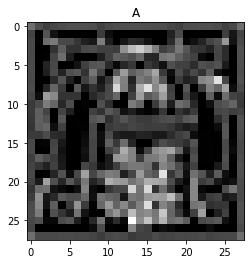

In [16]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0], cmap='gray')
plt.title("ABCDEFGHIJ"[y[i]]);

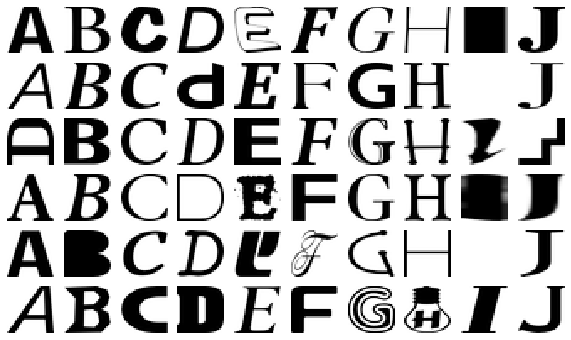

In [17]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [18]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [19]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

In [20]:
from tensorflow.keras.utils import to_categorical

In [24]:
class_n = len(np.unique(y_train))

In [25]:
y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

In [26]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Hidden Layer 3개까지!
3. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
4. Dropout을 0.2 정도로 활용해볼 것
5. Early stopping도 활용해볼 것

In [28]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout

In [29]:
## Sequential API

# 1. 세션 클리어
clear_session()

# 2. 레이어 블록 쌓을 발판 생성
model = Sequential()

# 3. 레이어 블록 조립
model.add( Input(shape=(28,28,1)) )
model.add( Flatten() )
model.add( Dense(64, activation='relu') )
model.add( BatchNormalization() )
model.add( Dense(64, activation='relu') )
model.add( BatchNormalization() )
model.add( Dense(64, activation='relu') )
model.add( BatchNormalization() )
model.add( Dropout(0.2) )
model.add( Dense(10, activation='softmax') )

# 4. 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                4

In [37]:
## Functional API

# 1. 세션 클리어
clear_session()

# 2. 레이어 사슬처럼 엮기
il = Input(shape=(28,28,1))
fl = Flatten()(il)
hl = Dense(64, activation='relu')(fl)
bl = BatchNormalization()(hl)
hl = Dense(64, activation='relu')(bl)
bl = BatchNormalization()(hl)
hl = Dense(64, activation='relu')(bl)
bl = BatchNormalization()(hl)
dl = Dropout(0.2)(bl)
ol = Dense(10, activation='softmax')(dl)

# 3. 모델의 시작과 끝 레이어 지정
model = Model(il, ol)

# 4. 컴파일
model.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'],
              optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

In [31]:
## Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
es = EarlyStopping(monitor='val_loss',       # 관측 대상
                   patience=5,               # 개선되지 않을 때, 몇 번 참을래
                   min_delta=0,              # 설정값 이상으로 개선되어야 개선 된 것으로 인정
                   verbose=1,                
                   restore_best_weights=True)# 학습 이후, 최적의 가중치를 모델에 전달

In [39]:
mcp = ModelCheckpoint(filepath='/content/model.ckpt',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False)

In [40]:
model.fit(x_train, y_train, validation_split=0.2, verbose=1, epochs=10000,
          callbacks=[es, mcp])

Epoch 1/10000
369/375 [============================>.] - ETA: 0s - loss: 0.7046 - accuracy: 0.7956
Epoch 1: val_loss improved from inf to 0.46851, saving model to /content/model.ckpt
375/375 [==============================] - 6s 12ms/step - loss: 0.7017 - accuracy: 0.7966 - val_loss: 0.4685 - val_accuracy: 0.8692
Epoch 2/10000
369/375 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8782
Epoch 2: val_loss improved from 0.46851 to 0.41599, saving model to /content/model.ckpt
375/375 [==============================] - 4s 11ms/step - loss: 0.4266 - accuracy: 0.8780 - val_loss: 0.4160 - val_accuracy: 0.8802
Epoch 3/10000
370/375 [============================>.] - ETA: 0s - loss: 0.3603 - accuracy: 0.8938
Epoch 3: val_loss improved from 0.41599 to 0.40429, saving model to /content/model.ckpt
375/375 [==============================] - 4s 9ms/step - loss: 0.3592 - accuracy: 0.8941 - val_loss: 0.4043 - val_accuracy: 0.8808
Epoch 4/10000
367/375 [=========================